# Customer Segmentation with RFM + K-Means Clustering  
### Data-Driven Marketing Strategy for an Online Retailer

**Goal:**  
Identify distinct customer segments (loyal, at-risk, high-value, low-value, etc.) using only transaction history — no labels, fully unsupervised — and turn that into actionable marketing strategy.

**Approach:**  
1. Clean real retail transaction data (invoices, products, spend).
2. Engineer RFM features:
   - **Recency**: How recently did the customer buy?
   - **Frequency**: How often do they buy?
   - **Monetary**: How much money have they spent?
3. Reduce skew, scale features, and cluster customers using K-Means.
4. Use Silhouette + Elbow to choose the number of clusters.
5. Interpret each cluster as a customer persona and visualize segments in PCA space.

**Business questions answered:**
- Which customers are most valuable?
- Which customers are slipping away and need win-back campaigns?
- Which customers are new and worth nurturing?

**Deliverables:**
- Labeled customer segments
- Marketing guidance per segment
- CSV of clustered customers for targeting

## 1. Load data and inspect schema

We start by loading the raw transactional dataset (Online Retail II).  
Each row is a single line item in an invoice: product, quantity, unit price, timestamp, and the customer ID.

We'll:
- Import libraries
- Read the CSV
- Quickly inspect the shape, types, and head

In [1]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np

import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score 
from sklearn.decomposition import PCA 

In [ ]:
df = pd.read_csv("DATA/online_retail_II.csv")

In [3]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [5]:
df.describe().round(2)

,Quantity,Price,Customer ID
count,1067371.00,1067371.00,824364.00
mean,9.94,4.65,15324.64
std,172.71,123.55,1697.46
min,-80995.00,-53594.36,12346.00
25%,1.00,1.25,13975.00
50%,3.00,2.10,15255.00
75%,10.00,4.15,16797.00
max,80995.00,38970.00,18287.00


In [6]:
df.shape

(1067371, 8)

**Quick observations:**
- `Customer ID` has missing values.
- Some rows have negative quantities / prices (likely returns or corrections).
- `InvoiceDate` is currently stored as string/object and needs to become datetime.
- Each row is *not* a customer — multiple rows per invoice per product.

We'll clean these before building customer-level features.


## 2. Data cleaning

Cleaning steps:
1. **Drop rows without `Customer ID`** – we can't assign purchases to a customer.
2. **Remove negative Quantity / Price** – these are returns/credits; we only want completed purchases for lifetime value modeling.
3. **Convert `InvoiceDate` to datetime** – we need this for recency.
4. **Sanity-check nulls again.**

After cleaning, every row is a valid purchase line mapped to a known customer.


In [7]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [8]:
df = df.dropna(subset=['Customer ID'])

In [9]:
df = df[(df['Quantity']>0) & (df['Price']>0)]

In [10]:
df.isnull().sum()


Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [11]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [12]:
df.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

In [13]:
df['Description'].value_counts()

Description
WHITE HANGING HEART T-LIGHT HOLDER    5181
REGENCY CAKESTAND 3 TIER              3428
ASSORTED COLOUR BIRD ORNAMENT         2777
JUMBO BAG RED RETROSPOT               2702
REX CASH+CARRY JUMBO SHOPPER          2141
                                      ... 
ASSORTED DESIGN GEISHA GIRL MUGS         1
S/3 ROSE GARDEN SCENT SQU CANDLE         1
CHOCOLATE ICE CREAM CANDLE               1
S/4 BLACK DISCO PARTITION PANEL          1
TINY CRYSTALS BRACELET BLACK             1
Name: count, Length: 5283, dtype: int64

In [14]:
df.describe() #Checking to see if I still have negative quantity and prices. 

,Quantity,InvoiceDate,Price,Customer ID
count,805549.000000,805549,805549.000000,805549.000000
mean,13.290522,2011-01-02 10:24:44.106814464,3.206561,15331.954970
min,1.000000,2009-12-01 07:45:00,0.001000,12346.000000
25%,2.000000,2010-07-07 12:08:00,1.250000,13982.000000
50%,5.000000,2010-12-03 15:10:00,1.950000,15271.000000
75%,12.000000,2011-07-28 13:05:00,3.750000,16805.000000
max,80995.000000,2011-12-09 12:50:00,10953.500000,18287.000000
std,143.634088,NaN,29.199173,1696.737039


After cleaning:
- All remaining rows have valid `Customer ID`.
- Only positive purchases remain (returns removed).
- We now have proper datetime `InvoiceDate`.
- We'll now engineer RFM features on a **per-customer** level.


## 3. Feature engineering: RFM

We'll compute the classic RFM features per customer:

- **Recency**  
  How many days since the customer's most recent purchase?  
  (Lower = more recent = more engaged.)

- **Frequency**  
  How many unique invoices has this customer placed?  
  (Higher = more loyal / habitual.)

- **Monetary**  
  Total spend across all purchases.  
  (Higher = higher value / CLV.)

We'll also create a `TotalPrice` column at the line-item level and then aggregate by customer.


In [15]:
df['TotalPrice'] = df["Quantity"] * df["Price"] #sum spending per customer

In [16]:
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1) #fixed date reference used to calculate how recent the customer bought something
print('snapshot_date:' ,snapshot_date)

rfm = df.groupby('Customer ID').agg({ #groups all transcations per customer
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, #Recency #to find how many days since last purchase
    'Invoice':'nunique', #frequency -> count how many unique invoices
    'TotalPrice': 'sum'   #monetary -> add up total money spent
}).reset_index() #reset index to keep it clean

rfm.rename(columns={
    'InvoiceDate':'Recency',
    'Invoice': 'Frequency',
    'TotalPrice':'Monetary'  
},inplace=True)

snapshot_date: 2011-12-10 12:50:00


In [17]:
print(rfm.shape)

(5878, 4)


## 4. Explore RFM distributions and remove extreme outliers

Before clustering, we inspect distributions of Recency / Frequency / Monetary:
- Monetary and Frequency often have extreme long tails (big spenders, wholesale buyers).
- Those extreme values can dominate distance-based clustering (like K-Means).

We'll:
1. Visualize the raw distributions.
2. Remove the top 1% of Monetary and Frequency to reduce extreme leverage.


In [18]:
rfm.head()

,Customer ID,Recency,Frequency,Monetary
0,12346.0,326,12,77556.46
1,12347.0,2,8,5633.32
2,12348.0,75,5,2019.40
3,12349.0,19,4,4428.69
4,12350.0,310,1,334.40


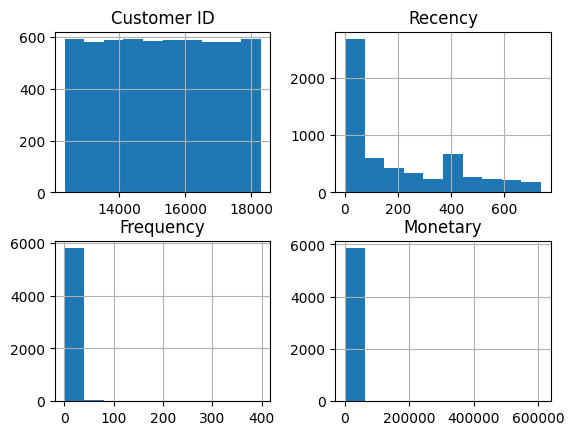

In [19]:
rfm.hist()
plt.show()

In [20]:
rfm.describe()

,Customer ID,Recency,Frequency,Monetary
count,5878.000000,5878.000000,5878.000000,5878.000000
mean,15315.313542,201.331916,6.289384,3018.616737
std,1715.572666,209.338707,13.009406,14737.731040
min,12346.000000,1.000000,1.000000,2.950000
25%,13833.250000,26.000000,1.000000,348.762500
50%,15314.500000,96.000000,3.000000,898.915000
75%,16797.750000,380.000000,7.000000,2307.090000
max,18287.000000,739.000000,398.000000,608821.650000


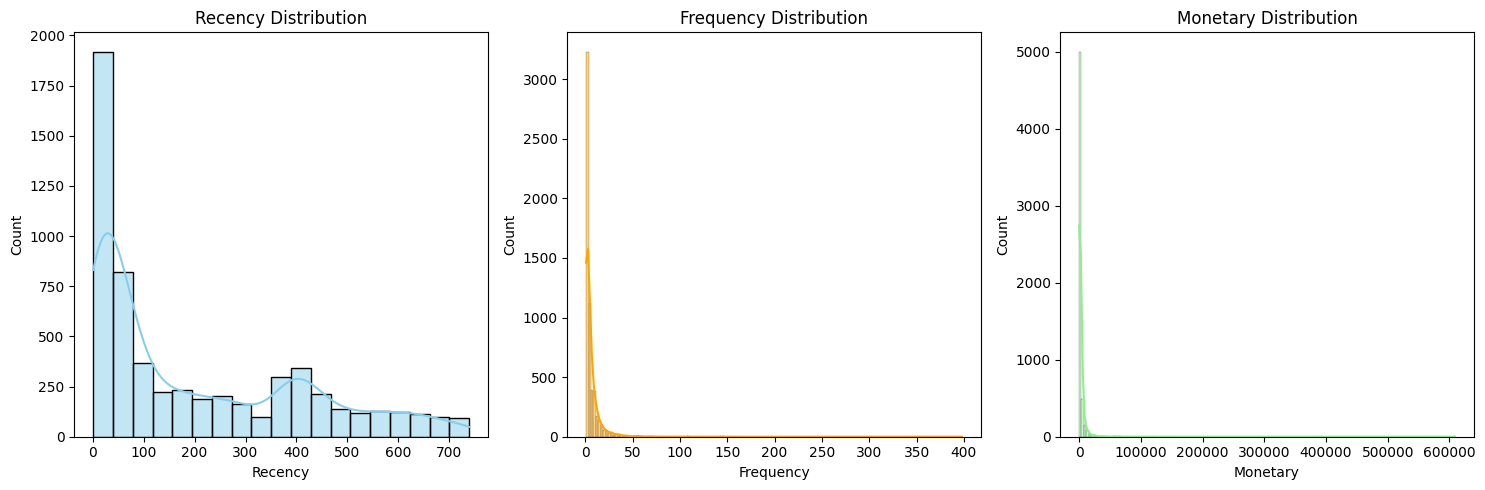

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(rfm['Recency'], ax=axes[0], kde=True, color='skyblue')
sns.histplot(rfm['Frequency'], ax=axes[1], kde=True, color='orange')
sns.histplot(rfm['Monetary'], ax=axes[2], kde=True, color='lightgreen')

axes[0].set_title('Recency Distribution')
axes[1].set_title('Frequency Distribution')
axes[2].set_title('Monetary Distribution')

plt.tight_layout()
plt.show()


In [22]:
rfm = rfm[rfm['Monetary'] < rfm['Monetary'].quantile(0.99)] #to remove customers with extremely high spend

In [23]:
rfm = rfm[rfm['Frequency'] < rfm['Frequency'].quantile(0.99)] #even if you dont u will still get same results as graph below where monetary is at 7 so this is optional

In [24]:
rfm.describe()

,Customer ID,Recency,Frequency,Monetary
count,5757.000000,5757.000000,5757.000000,5757.000000
mean,15316.645475,204.785652,5.063748,1931.117670
std,1713.880536,209.630297,5.664153,3017.417773
min,12347.000000,1.000000,1.000000,2.950000
25%,13837.000000,28.000000,1.000000,341.360000
50%,15318.000000,103.000000,3.000000,854.990000
75%,16798.000000,382.000000,6.000000,2140.280000
max,18287.000000,739.000000,35.000000,28882.440000


In [25]:
rfm.isna().sum()

Customer ID    0
Recency        0
Frequency      0
Monetary       0
dtype: int64

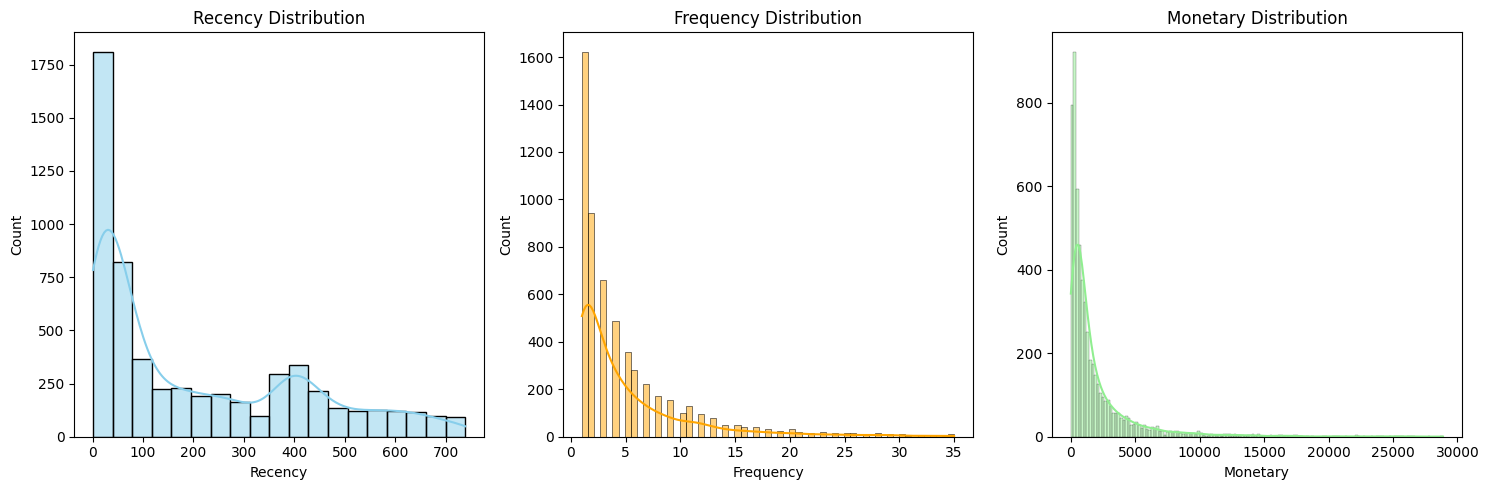

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(rfm['Recency'], ax=axes[0], kde=True, color='skyblue')
sns.histplot(rfm['Frequency'], ax=axes[1], kde=True, color='orange')
sns.histplot(rfm['Monetary'], ax=axes[2], kde=True, color='lightgreen')

axes[0].set_title('Recency Distribution')
axes[1].set_title('Frequency Distribution')
axes[2].set_title('Monetary Distribution')
plt.tight_layout()
plt.show()


**Observation:**  
- `Monetary` and `Frequency` are extremely right-skewed (few very high spenders/bulk buyers).
- We'll cap extreme values at the 99th percentile to prevent them from dominating the clusters.


## 5. Normalize features for clustering

K-Means uses Euclidean distance, so:
- Features on larger scales dominate.
- Highly skewed features (like Monetary) can make clusters unstable.

Steps:
1. Apply `log1p` transform to Recency / Frequency / Monetary to reduce skew.
2. Standardize (mean=0, std=1) so all features contribute equally.
3. Inspect the correlation heatmap of the scaled features.


Log Transform (to reduce skewness) -> np.log1p(x) means log(1 + x) → safe for zeros. Reduces skewness and normalizes value spread.

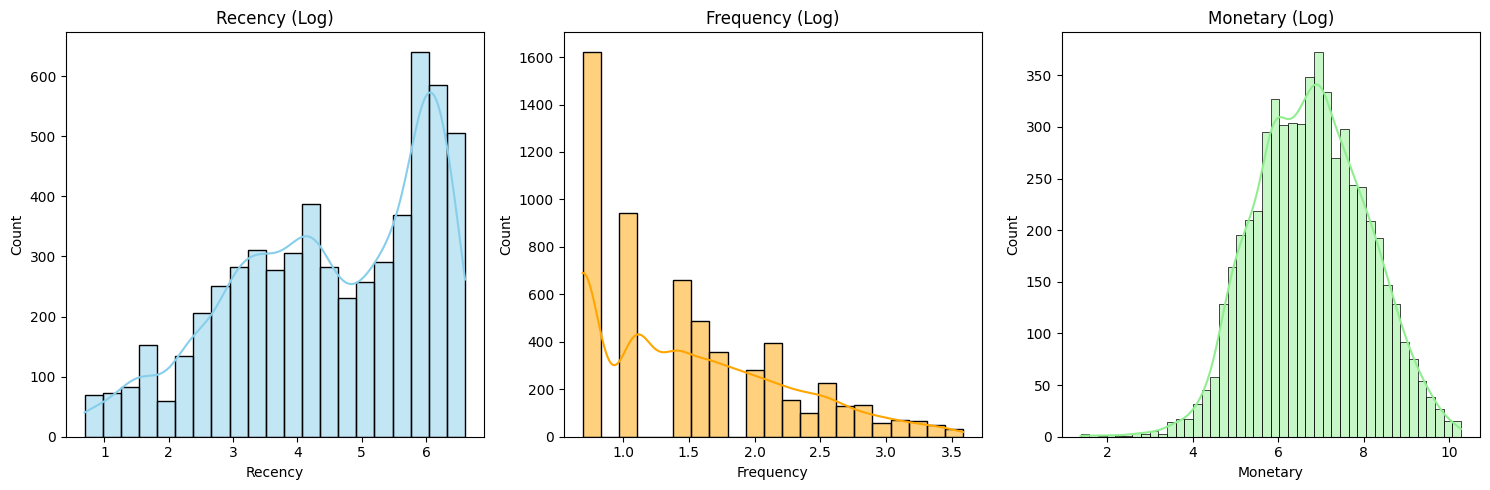

In [27]:
rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].apply(lambda x:np.log1p(x)) 

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(rfm_log['Recency'], ax=axes[0], kde=True, color='skyblue')
sns.histplot(rfm_log['Frequency'], ax=axes[1], kde=True, color='orange')
sns.histplot(rfm_log['Monetary'], ax=axes[2], kde=True, color='lightgreen')

axes[0].set_title('Recency (Log)')
axes[1].set_title('Frequency (Log)')
axes[2].set_title('Monetary (Log)')
plt.tight_layout()
plt.show()

Scaling the features to contribute equally since K-Means uses Euclidean distance.

In [28]:
scaler = StandardScaler()

rfm_scaled = scaler.fit_transform(rfm_log)

Converting back to DataFrame (for readability)

In [29]:
rfm_scaled = pd.DataFrame(
    rfm_scaled,
    index=rfm.index,
    columns=["Recency", 'Frequency', 'Monetary']
)

In [30]:
rfm_scaled.head() #now every column has mean = 0 , std = 1 

,Recency,Frequency,Monetary
1,-2.230811,0.952785,1.443627
2,-0.112501,0.399009,0.653354
3,-0.987452,0.149998,1.258271
4,0.810986,-1.101455,-0.730364
5,0.935378,-1.101455,-0.811373


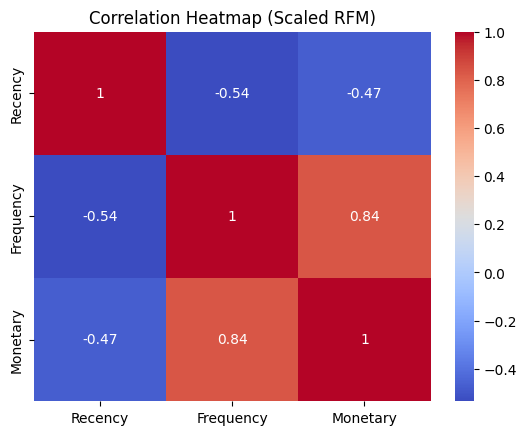

In [31]:
sns.heatmap(rfm_scaled.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap (Scaled RFM)')
plt.show()

After transformation:
- All three features are on comparable scales.
- No single feature should dominate K-Means distance.
- We're now ready to choose the number of clusters.


## 6. How many clusters? (Elbow & Silhouette)

We test `k = 2 ... 10` and use:
- **Elbow / Inertia**: how much within-cluster variance is explained.
- **Silhouette Score**: how well-separated the clusters are (higher = better, >0.5 is usually decent for real data).

We'll pick a `k` that balances separation and stability.


Finding The Optimal Number of Clusters (Elbow & Silhouette).

The Elow method is where adding another cluster stops giving big gains.

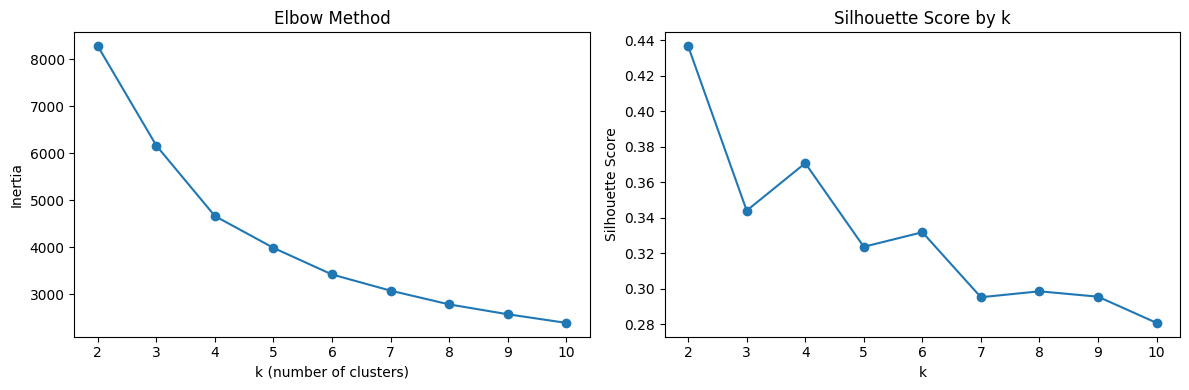

In [32]:
inertias = []
sil_scores = [] 

K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(rfm_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(rfm_scaled, labels)) #Sillhoutte score measures how well each point fits its cluster (1 = perfect separation)

# Plot elbow
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(K_range, inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('k (number of clusters)')
plt.ylabel('Inertia')

plt.subplot(1,2,2)
plt.plot(K_range, sil_scores, marker='o')
plt.title('Silhouette Score by k')
plt.xlabel('k')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

We select `k = 4` (good Silhouette separation and reasonable elbow), and train final K-Means with that value.


## 7. Train final K-Means and assign segments

Using the chosen `k`, we:
- Fit K-Means on the scaled RFM features.
- Assign every customer to a cluster.
- Summarize each cluster's average Recency / Frequency / Monetary.


In [33]:
best_k = 4

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

rfm.head()


,Customer ID,Recency,Frequency,Monetary,Cluster
1,12347.0,2,8,5633.32,1
2,12348.0,75,5,2019.40,0
3,12349.0,19,4,4428.69,1
4,12350.0,310,1,334.40,2
5,12351.0,375,1,300.93,2


In [34]:
cluster_summary = (
    rfm.groupby('Cluster')
       .agg({
           'Recency': 'mean',
           'Frequency': 'mean',
           'Monetary': ['mean', 'count'] 
       })
       .round(1)
)

cluster_summary.columns = [
    'RecencyMean', 'FrequencyMean', 'MonetaryMean', 'NumCustomers'
]

cluster_summary = cluster_summary.sort_values(by='MonetaryMean', ascending=False)  #To better understand the cluster profiles by representing the average RFM
cluster_summary 

,RecencyMean,FrequencyMean,MonetaryMean,NumCustomers
Cluster,,,,
1,31.3,13.2,5613.1,1272
0,247.8,4.6,1729.7,1430
3,30.1,2.8,785.1,1187
2,400.9,1.3,306.3,1868


Recency is measured in number of days since last purchase when we took the snapshot, so lower is actually better / more recent activity; to avoid confusion because “Recency = 5” is better than “Recency = 120”.
---

In [35]:
def label_segment(row):
    if row['RecencyMean'] < 30 and row['FrequencyMean'] > 5 and row['MonetaryMean'] > 1000:
        return "High-Value Loyalist"
    elif row['RecencyMean'] > 90 and row['MonetaryMean'] > 800:
        return "At-Risk Big Spender"
    elif row['FrequencyMean'] <= 2 and row['MonetaryMean'] < 200:
        return "Low-Value / Occasional"
    else:
        return "Active Mid-Spend"

cluster_summary['SegmentName'] = cluster_summary.apply(label_segment, axis=1)
cluster_summary

,RecencyMean,FrequencyMean,MonetaryMean,NumCustomers,SegmentName
Cluster,,,,,
1,31.3,13.2,5613.1,1272,Active Mid-Spend
0,247.8,4.6,1729.7,1430,At-Risk Big Spender
3,30.1,2.8,785.1,1187,Active Mid-Spend
2,400.9,1.3,306.3,1868,Active Mid-Spend


### Interpreting clusters as marketing personas

How to read this:
- **RecencyMean (lower = better)**  
  Lower Recency → they bought recently → "active / engaged".
- **FrequencyMean (higher = better)**  
  Higher Frequency → they buy often → "loyal / habitual".
- **MonetaryMean (higher = $$$)**  
  Higher Monetary → high-value / high-CLV customers.

From this table we can label segments such as:
1. **High-Value Loyalists**  
   Low Recency, high Frequency, high Monetary.  
   → Keep them happy, give VIP perks, early access, loyalty rewards.

2. **At-Risk Big Spenders**  
   High Monetary, but Recency is high (they haven't bought in a long time).  
   → Win-back campaign, targeted email, "We miss you" coupons.

3. **New / Low Spend**  
   Low Frequency, low Monetary, decent Recency.  
   → Nurture/upsell, onboarding flows, recommendation emails.

4. **Bargain / Occasional Buyers**  
   Buy infrequently and spend less.  
   → Hit them during sales and promotions.

This is how we turn unsupervised learning into targeting strategy.


## 8. Visualize clusters in 2D (PCA)

To sanity check that the segments are separable, we:
- Run PCA to project the scaled RFM features to 2 dimensions.
- Color points by cluster.

If the clusters are meaningful, we should see distinct regions.


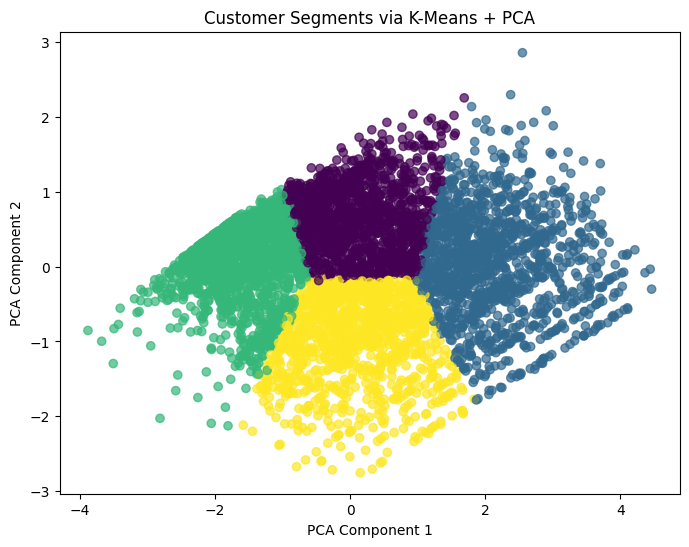

In [36]:
pca = PCA(n_components=2, random_state=42)
rfm_pca = pca.fit_transform(rfm_scaled)

plt.figure(figsize=(8,6))
plt.scatter(
    rfm_pca[:,0],
    rfm_pca[:,1],
    c=rfm['Cluster'],
    cmap='viridis',
    alpha=0.7
)
plt.title('Customer Segments via K-Means + PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

## 9. Cluster-level RFM profiles

This plot shows, for each cluster, the average Recency / Frequency / Monetary side-by-side.

This is a great way to communicate "Cluster 2 = whales" vs "Cluster 3 = at-risk" to non-technical stakeholders.


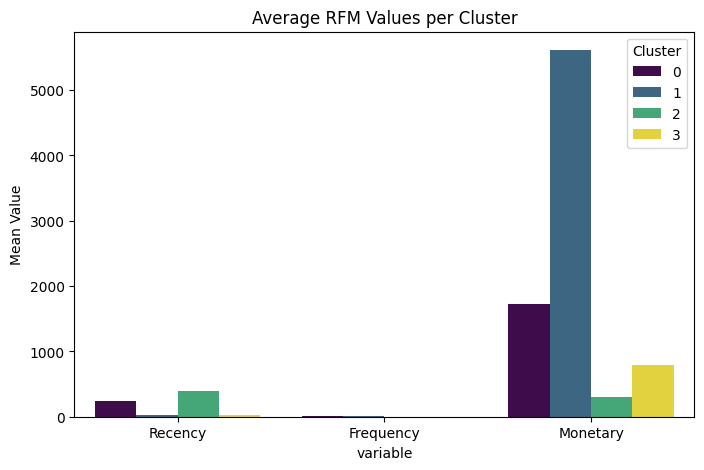

In [37]:
rfm_melted = rfm.groupby('Cluster')[['Recency','Frequency','Monetary']].mean().reset_index()
rfm_melted = pd.melt(rfm_melted, id_vars='Cluster')

plt.figure(figsize=(8,5))
sns.barplot(data=rfm_melted, x='variable', y='value', hue='Cluster', palette='viridis')
plt.title('Average RFM Values per Cluster')
plt.ylabel('Mean Value')
plt.show()

## 10. Export labeled customers

Finally, we export the `rfm` DataFrame (with the assigned `Cluster`) so this can be:
- joined back to CRM,
- used for campaign targeting,
- given to marketing / lifecycle teams.

**Note:** For a real business, you'd anonymize or hash Customer ID before sharing outside analytics.


In [38]:
rfm.to_csv('clustered_customers.csv', index=False)

---

## Appendix

**Environment / Reproducibility**
- Python version: 3.x
- Libraries:
  - pandas
  - numpy
  - seaborn
  - matplotlib
  - scikit-learn

**Why RFM?**
RFM is a classic, interpretable behavioral fingerprint:
- It's lightweight to compute (purely transactional).
- It's easy to explain to marketing, lifecycle, and CRM teams.
- It's actionable: you can directly target clusters with win-back promos, loyalty perks, churn-prevention campaigns, etc.

**Why Unsupervised?**
We didn't assume any labels (no "high-value" tag, no "churn" tag).  
We *discovered* segments from raw behavior.  
This is useful when:
- You don't have labeled churn data.
- You want to explore and summarize your base.
- You want explainable segments you can act on immediately.

**Next steps**
- Track cluster migration over time (who is slipping from Loyalist → At-Risk Big Spender?).
- Add CLV features (total margin, not just revenue).
- Layer geography or category preference on top of the clusters.
- Personalize offers and retention strategy by segment.
